# Comparison between deepchaos (official library) with edge-of-chaos (personal lib.)

In [1]:
import numpy as np
from tqdm import tqdm
import pickle
from scipy.stats import hypsecant
from cornet.constants import *
from cornet.theory import qmap, q_fixed_point, compute_chi1, covmap
import torch
import invint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [15, 10]

In [2]:
def sech(x):
    return hypsecant.pdf(x) * np.pi

tanh = np.tanh
tanh_p = lambda x: sech(x)**2
tanh_pp = lambda x: 2 * (np.tanh(x)**3 - np.tanh(x))

elu = lambda x: np.where(x > 0, x, np.exp(x) - 1)
elu_p = lambda x: np.where(x > 0, 1, np.exp(x))
elu_pp = lambda x: np.where(x > 0, 0, np.exp(x))

phi = np.tanh
dphi = lambda x: sech(x)**2
d2phi = lambda x: 2 * (np.tanh(x)**3 - np.tanh(x))

In [3]:
print("Weight sigmas (n=%d):" % nw, weight_sigmas)
print("Bias sigmas (n=%d):" % nb, bias_sigmas)

Weight sigmas (n=41): [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5
 4.6 4.7 4.8 4.9 5. ]
Bias sigmas (n=41): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4. ]


In [4]:
# Range of squared lengths for q map plot (panel A)
nq = 100
qmax = 15
qrange = np.linspace(0, qmax, nq)

qstars = np.zeros((nw, nb))
chi1 = np.zeros((nw, nb))

nq = 51
c12s = np.linspace(0, 1.0, nq)
crange = c12s
cstars = np.zeros((nw, nb))

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        # Compute fixed points
        _, qstar = q_fixed_point(weight_sigma, bias_sigma, phi, qinit=3.0, tol_frac=0.01)
        qstars[widx, bidx] = qstar
        
        chi1[widx, bidx] = compute_chi1(qstar, weight_sigma, bias_sigma, dphi)
        
        cin = (c12s * qstar)
        cout = covmap(qstar, qstar,  cin, weight_sigma, bias_sigma, phi)
        # Remove  fixed point at cin = q*
        cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
        cstars[widx, bidx] = cstar
        
cstars_unnormalized = cstars.copy()
cstars /= qstars

  0%|                                                                                                                                 | 0/41 [00:00<?, ?it/s]/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frac_err = (np.array(qs) - q)**2 / (1e-9 + q**2)
  0%|                                                                                                                                 | 0/41 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Tests with $\phi_{\theta}$ activation functions

In [5]:
def load_acttorch_torch(theta):
    zmin = .0001
    zmax = 5
    znum = 200
    max_err = .02
    xmax = 10
    npts = 100
    restart = False

    path_store = './'

    fs_acttorch = invint.FileStorage('../functions/InvInt_acttorch_theta-{:.4f}_err-{:.2e}_zmin-{:.2e}_zmax-{:.2e}_' + \
                                         'znum-{}_xmax-{:.2f}_npts-{}_torch_.pkl', \
        {'theta': float, 'err': float, 'zmin': float, 'zmax': float, 'znum': int, 'xmax': float,  'npts': int})

    fname_all = fs_acttorch.find_all(path_store, \
        {'theta': theta, 'zmin': zmin, 'zmax': zmax, 'znum': znum, 'xmax': xmax, 'npts': npts})
    
    if len(fname_all) == 0:
        raise ValueError('No torch activation function file found for theta = {:.2f}'.format(theta))
        
    best_fname = min(fname_all, key = lambda k: fname_all[k]['err'])

    print('Loading...')
    dct_load = torch.load(best_fname)
    
    acttorch = invint.ActivationFunction(theta)
    acttorch.load_state_dict(dct_load['acttorch'])
    err = fs_acttorch.extract_dct(best_fname)['err']
    err_torch = dct_load['err_torch']
    print('Done.')
    
    return {'acttorch': acttorch, 'err': err, 'err_torch': err_torch}

In [6]:
lst_theta = [2.06, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]
acttorch_torch = {}
for theta in lst_theta:
    dct = load_acttorch_torch(theta)
    acttorch_torch[theta] = dct['acttorch']

Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.


Text(0.5, 1.0, 'Activation function')

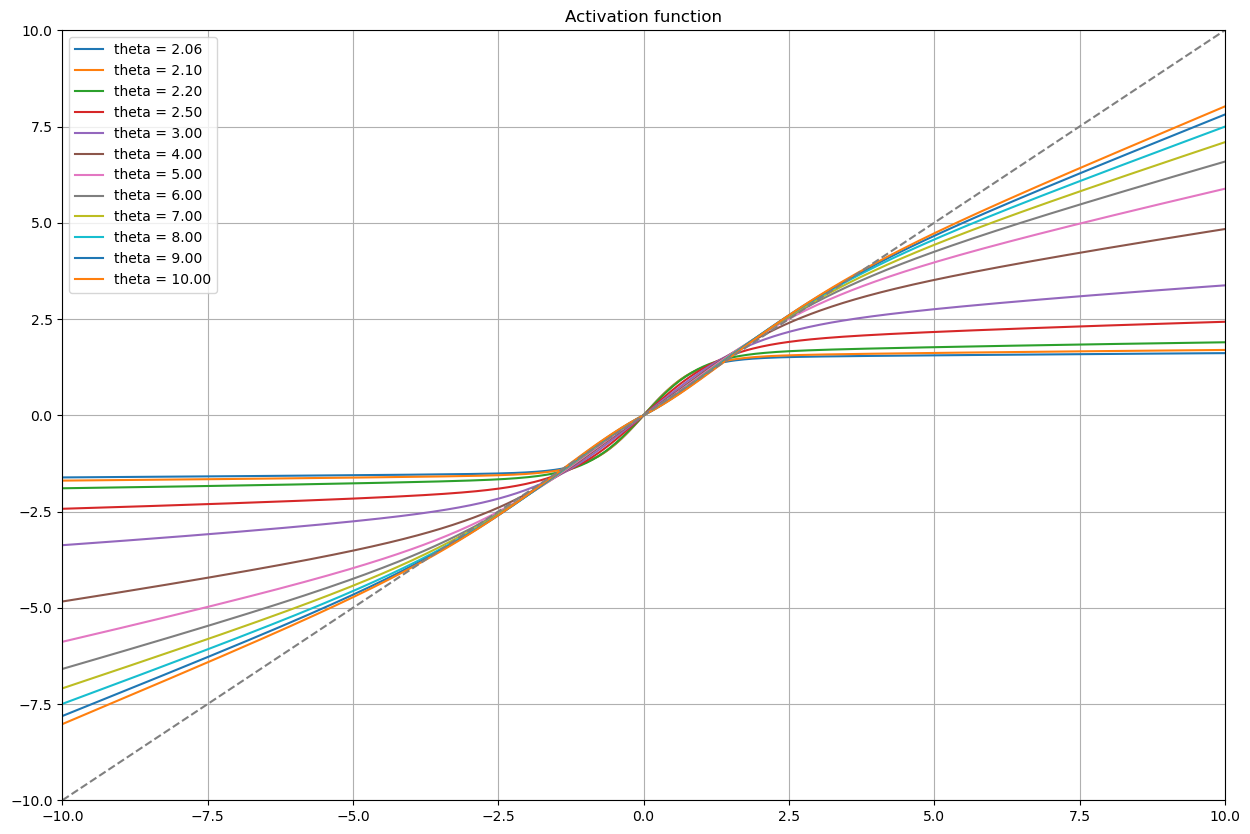

In [7]:
lst_x = np.linspace(-10, 10, 400)

for theta, acttorch in acttorch_torch.items():
    plt.plot(lst_x, acttorch.forward_ng(lst_x), label = 'theta = {:.2f}'.format(theta))

plt.plot([-10, 10], [-10, 10], color = 'grey', linestyle = 'dashed')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid(True)
plt.legend()
plt.title('Activation function')

In [8]:
dct_phi = {theta: acttorch.forward_ng for theta, acttorch in acttorch_torch.items()}
dct_phi_p = {theta: acttorch.derivative_ng for theta, acttorch in acttorch_torch.items()}
dct_phi_pp = {theta: acttorch.derivative2_ng for theta, acttorch in acttorch_torch.items()}

In [40]:
# Generate EOC, v01

for theta in lst_theta:
    print("theta = {:.2f}".format(theta))
    phi = lambda x: dct_phi[theta](torch.tensor(x)).numpy()
    dphi = lambda x: dct_phi_p[theta](torch.tensor(x)).numpy()

    # Range of squared lengths for q map plot (panel A)
    nq = 100
    qmax = 15
    qrange = np.linspace(0, qmax, nq)

    qstars = np.zeros((nw, nb))
    chi1 = np.zeros((nw, nb))

    nq = 51
    c12s = np.linspace(0, 1.0, nq)
    crange = c12s
    cstars = np.zeros((nw, nb))

    for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
        for bidx, bias_sigma in enumerate(bias_sigmas):
            # Compute fixed points
            _, qstar = q_fixed_point(weight_sigma, bias_sigma, phi, qinit=3.0, tol_frac=0.01)
            qstars[widx, bidx] = qstar

            chi1[widx, bidx] = compute_chi1(qstar, weight_sigma, bias_sigma, dphi)

            cin = (c12s * qstar)
            cout = covmap(qstar, qstar,  cin, weight_sigma, bias_sigma, phi)
            # Remove  fixed point at cin = q*
            cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
            cstars[widx, bidx] = cstar

    cstars_unnormalized = cstars.copy()
    cstars /= qstars
    
    dct_pickle = {'qstars': qstars, 'chi1': chi1, 'cstars': cstars, \
                  'weight_sigmas': weight_sigmas, 'bias_sigmas': bias_sigmas}
    pickle.dump(dct_pickle, open('EOC_v01_theta-{:.2f}.pkl'.format(theta), 'wb'))

theta = 2.06


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:12<00:00, 13.48s/it]


theta = 2.10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:17<00:00, 13.61s/it]


theta = 2.20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:16<00:00, 13.56s/it]


theta = 2.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:04<00:00, 13.29s/it]


theta = 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:19<00:00, 13.64s/it]


theta = 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:38<00:00, 14.11s/it]


theta = 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [10:06<00:00, 14.79s/it]


theta = 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [10:33<00:00, 15.44s/it]


theta = 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [10:47<00:00, 15.79s/it]


theta = 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [11:10<00:00, 16.34s/it]


theta = 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [11:14<00:00, 16.45s/it]


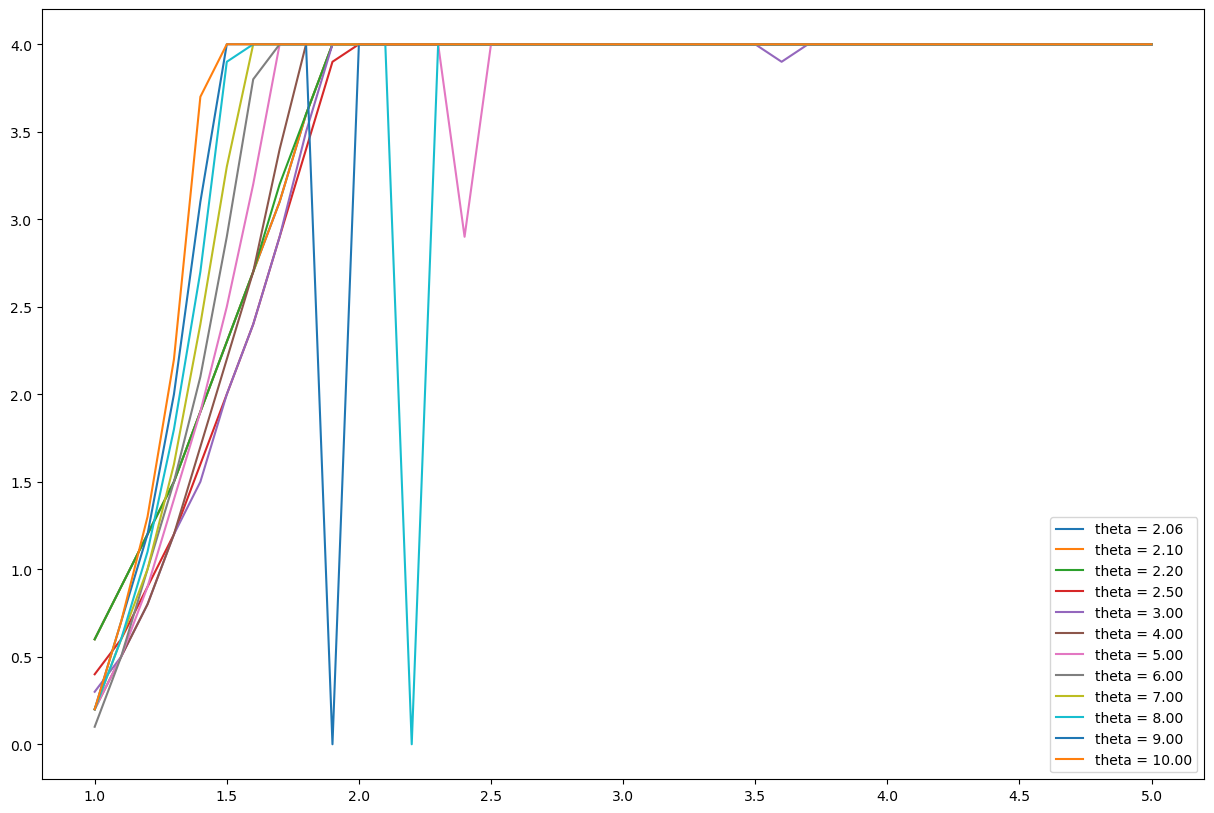

In [60]:
for theta in lst_theta:
    dct_pickle = pickle.load(open('EOC_v01_theta-{:.2f}.pkl'.format(theta), 'rb'))

    chi1 = dct_pickle['chi1']
    weight_sigmas = dct_pickle['weight_sigmas']
    bias_sigmas_star = np.empty_like(weight_sigmas)
    for widx, weight_sigma in enumerate(weight_sigmas):
        bidx = np.argmin(np.abs(chi1[widx, :] - 1))
        bias_sigmas_star[widx] = bias_sigmas[bidx]
        #print('bidx = {} ; bias_sigma = {:.3f} ; chi1 = {:.3f}'.format(bidx, bias_sigmas[bidx], chi1[widx, bidx]))
    plt.plot(weight_sigmas, bias_sigmas_star, label = 'theta = {:.2f}'.format(theta))
    
plt.legend()

In [11]:
weight_sigmas = np.linspace(.1, 2.5, 49)
bias_sigmas = np.linspace(0., 10., 101)
nw = len(weight_sigmas)
nb = len(bias_sigmas)
print("Weight sigmas (n=%d):" % nw, weight_sigmas)
print("Bias sigmas (n=%d):" % nb, bias_sigmas)

def generate_eoc_v2(phi, dphi):
    # Range of squared lengths for q map plot (panel A)
    nq = 100
    qmax = 15
    qrange = np.linspace(0, qmax, nq)

    qstars = np.zeros((nw, nb))
    chi1 = np.zeros((nw, nb))

    nq = 51
    c12s = np.linspace(0, 1.0, nq)
    crange = c12s
    cstars = np.zeros((nw, nb))

    for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
        for bidx, bias_sigma in enumerate(bias_sigmas):
            # Compute fixed points
            _, qstar = q_fixed_point(weight_sigma, bias_sigma, phi, qinit=3.0, tol_frac=0.01)

            if qstar is None:
                qstars[widx, bidx] = np.nan
                chi1[widx, bidx] = np.nan
                cstars[widx, bidx] = np.nan
            else:
                qstars[widx, bidx] = qstar
                
                chi1[widx, bidx] = compute_chi1(qstar, weight_sigma, bias_sigma, dphi)
                
                cin = (c12s * qstar)
                cout = covmap(qstar, qstar,  cin, weight_sigma, bias_sigma, phi)
                # Remove  fixed point at cin = q*
                cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
                cstars[widx, bidx] = cstar

    cstars_unnormalized = cstars.copy()
    not_nan = np.invert(np.isnan(cstars))
    cstars[not_nan] /= qstars[not_nan]
    
    dct_pickle = {'qstars': qstars, 'chi1': chi1, 'cstars': cstars, \
                  'weight_sigmas': weight_sigmas, 'bias_sigmas': bias_sigmas}
    
    return dct_pickle

Weight sigmas (n=49): [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45
 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15
 2.2  2.25 2.3  2.35 2.4  2.45 2.5 ]
Bias sigmas (n=101): [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]


In [74]:
# Generate EOC, v02

for theta in lst_theta:
    print("theta = {:.2f}".format(theta))
    phi = lambda x: dct_phi[theta](torch.tensor(x)).numpy()
    dphi = lambda x: dct_phi_p[theta](torch.tensor(x)).numpy()
    
    dct_pickle = generate_eoc_v2(phi, dphi)
    pickle.dump(dct_pickle, open('EOC_v02_theta-{:.2f}.pkl'.format(theta), 'wb'))

theta = 2.06


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [27:45<00:00, 33.99s/it]


theta = 2.10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [27:47<00:00, 34.03s/it]


theta = 2.20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [27:43<00:00, 33.95s/it]


theta = 2.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [26:46<00:00, 32.80s/it]


theta = 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [26:44<00:00, 32.75s/it]


theta = 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [26:51<00:00, 32.88s/it]


theta = 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [27:17<00:00, 33.41s/it]


theta = 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [27:58<00:00, 34.26s/it]


theta = 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [28:42<00:00, 35.15s/it]


theta = 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [29:33<00:00, 36.19s/it]


theta = 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [29:19<00:00, 35.92s/it]


theta = 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [30:04<00:00, 36.83s/it]


In [107]:
# Generate EOC tanh, v02

dct_pickle = generate_eoc_v2(tanh, tanh_p)
pickle.dump(dct_pickle, open('EOC_v02_phi-tanh.pkl', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [15:44<00:00, 19.28s/it]


In [10]:
_, qstar = q_fixed_point(1.7, 3.3, elu, qinit=3.0, tol_frac=0.01)
print(qstar)

[2.55845619e+81]


/tmp/ipykernel_107191/2147038865.py:8: RuntimeWarning: overflow encountered in exp
  elu = lambda x: np.where(x > 0, x, np.exp(x) - 1)
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frac_err = (np.array(qs) - q)**2 / (1e-9 + q**2)
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:81: UserWarning: Warning: q_star = 2.5585e+81.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))


In [12]:
# Generate EOC ELU, v02

dct_pickle = generate_eoc_v2(elu, elu_p)
pickle.dump(dct_pickle, open('EOC_v02_phi-elu.pkl', 'wb'))

 53%|███████████████████████████████████████████████████████████████▋                                                        | 26/49 [06:26<06:12, 16.18s/it]/tmp/ipykernel_107847/2147038865.py:8: RuntimeWarning: overflow encountered in exp
  elu = lambda x: np.where(x > 0, x, np.exp(x) - 1)
 55%|██████████████████████████████████████████████████████████████████                                                      | 27/49 [06:47<06:23, 17.45s/it]/tmp/ipykernel_107847/2147038865.py:9: RuntimeWarning: overflow encountered in exp
  elu_p = lambda x: np.where(x > 0, 1, np.exp(x))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:61: RuntimeWarning: invalid value encountered in sqrt
  u3 = np.sqrt(q2 - q12**2 / q1 + 1e-8)
 57%|████████████████████████████████████████████████████████████████████▌                                                   | 28/49 [07:10<06:42, 19.15s/it]/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 3.39

/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.2393e+27.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.5082e+27.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.7832e+27.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 7.0642e+27.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 7.3512e+27.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 7.6442e+27.
  warnings.warn("Warning: q_star = {:.4e}.".

/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.6497e+28.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.7061e+28.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.7631e+28.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.8207e+28.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.8789e+28.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.9377e+28.
  warnings.warn("Warning: q_star = {:.4e}.".

/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 5.7245e+41.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 5.9893e+41.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.2605e+41.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.5382e+41.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 6.8224e+41.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 7.1131e+41.
  warnings.warn("Warning: q_star = {:.4e}.".

/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.6340e+42.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.6923e+42.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.7513e+42.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.8110e+42.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.8713e+42.
  warnings.warn("Warning: q_star = {:.4e}.".format(q[0]))
/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:87: UserWarning: Warning: q_star = 2.9322e+42.
  warnings.warn("Warning: q_star = {:.4e}.".

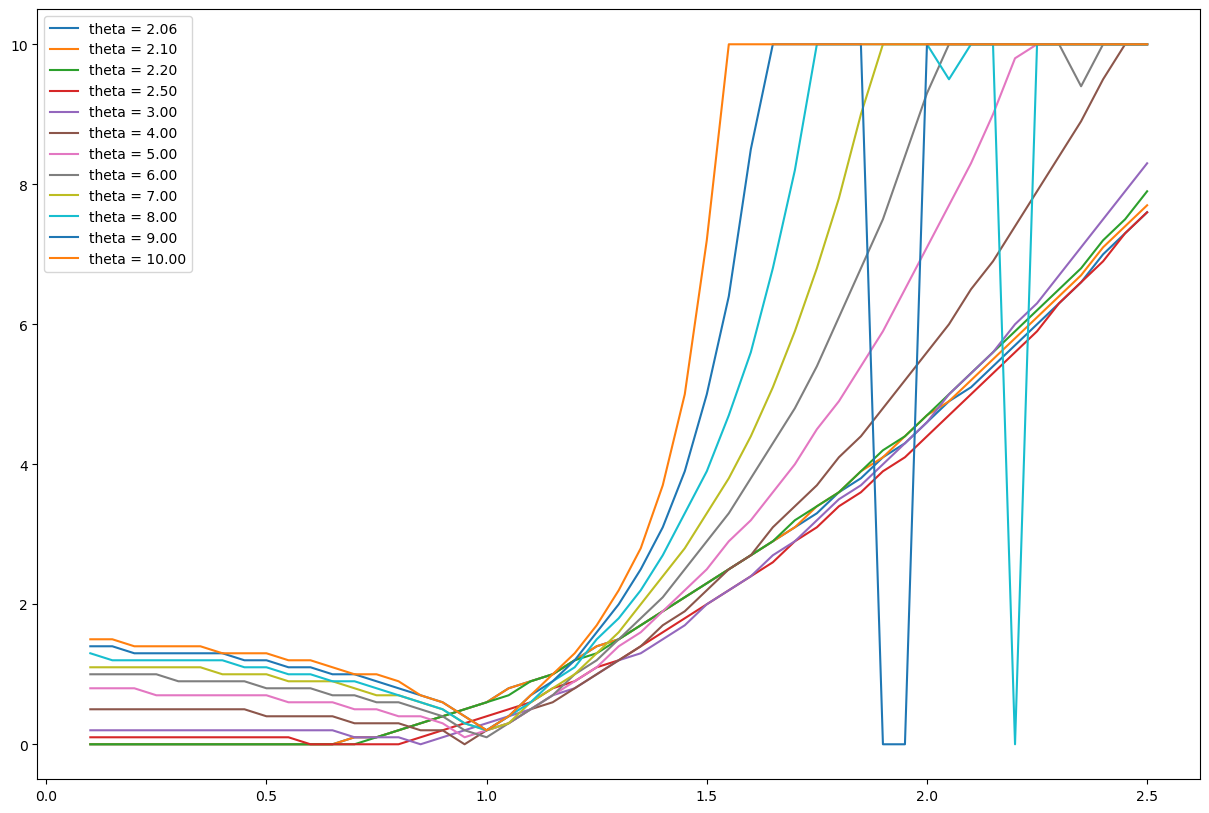

In [75]:
for theta in lst_theta:
    dct_pickle = pickle.load(open('EOC_v02_theta-{:.2f}.pkl'.format(theta), 'rb'))

    chi1 = dct_pickle['chi1']
    weight_sigmas = dct_pickle['weight_sigmas']
    bias_sigmas_star = np.empty_like(weight_sigmas)
    for widx, weight_sigma in enumerate(weight_sigmas):
        bidx = np.argmin(np.abs(chi1[widx, :] - 1))
        bias_sigmas_star[widx] = bias_sigmas[bidx]
        #print('bidx = {} ; bias_sigma = {:.3f} ; chi1 = {:.3f}'.format(bidx, bias_sigmas[bidx], chi1[widx, bidx]))
    plt.plot(weight_sigmas, bias_sigmas_star, label = 'theta = {:.2f}'.format(theta))
    
plt.legend()

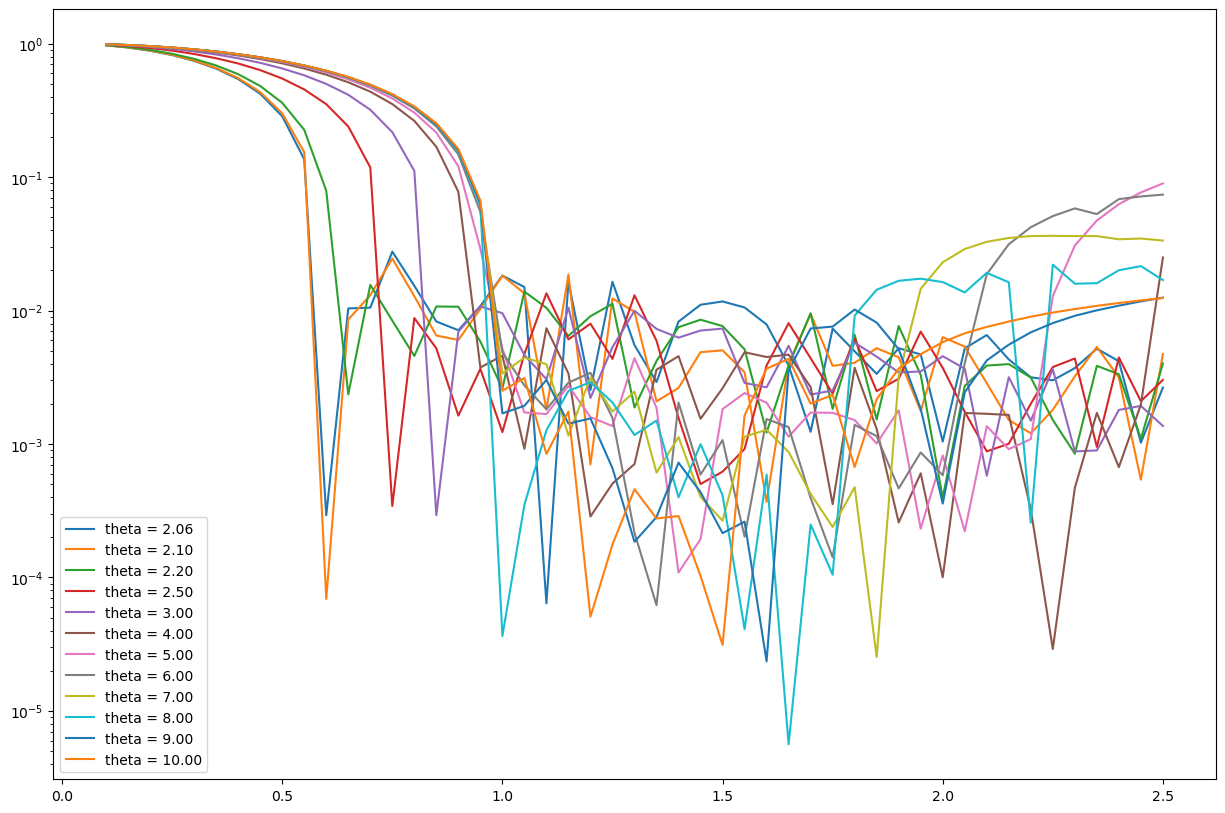

In [78]:
for theta in lst_theta:
    dct_pickle = pickle.load(open('EOC_v02_theta-{:.2f}.pkl'.format(theta), 'rb'))

    chi1 = dct_pickle['chi1']
    weight_sigmas = dct_pickle['weight_sigmas']
    bias_chi1_diff = np.empty_like(weight_sigmas)
    for widx, weight_sigma in enumerate(weight_sigmas):
        bias_chi1_diff[widx] = np.min(np.abs(chi1[widx, :] - 1))
    plt.plot(weight_sigmas, bias_chi1_diff, label = 'theta = {:.2f}'.format(theta))
    
plt.legend()
plt.yscale('log')

In [45]:
def compute_bias_sigmas_star(dct_pickle):
    chi1 = dct_pickle['chi1']
    weight_sigmas = dct_pickle['weight_sigmas']
    bias_sigmas_star = np.full_like(weight_sigmas, np.nan, dtype = float)
    for widx, weight_sigma in enumerate(weight_sigmas):
        if np.isnan(chi1[widx, :]).any():
            bias_sigmas_star[widx] = np.nan
            continue
        
        bidxs = np.abs(chi1[widx, :] - 1)
        if (bidxs == bidxs[0]).all():
            bidx = len(bias_sigmas) - 1
        else:
            bidx = np.argmin(bidxs)
        bias_sigmas_star[widx] = bias_sigmas[bidx]
        
        if bidx == len(bias_sigmas) - 1:
            break
            
    amin = len(bias_sigmas_star) - np.nanargmin(bias_sigmas_star[::-1]) - 1
    bias_sigmas_star[:amin] = np.nan
    
    return bias_sigmas_star

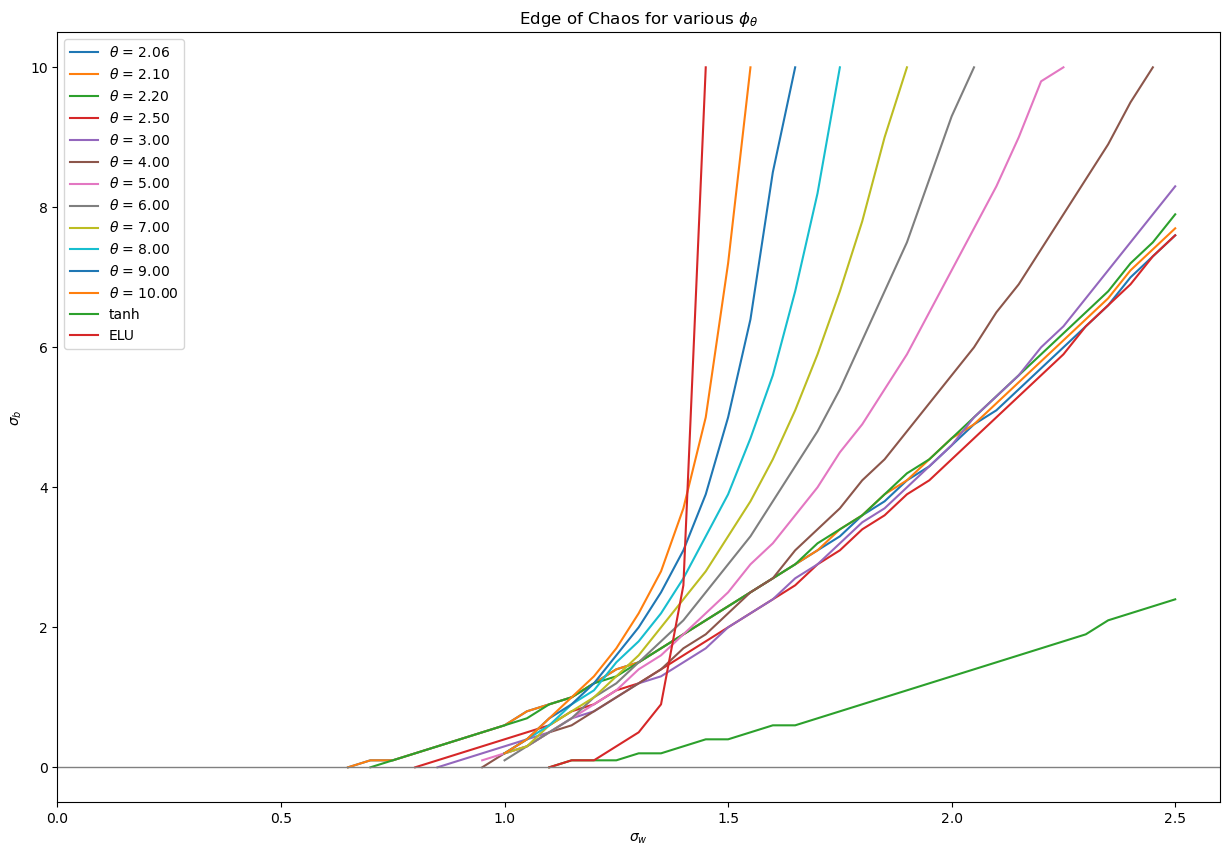

In [47]:
for theta in lst_theta:
    dct_pickle = pickle.load(open('EOC_v02_theta-{:.2f}.pkl'.format(theta), 'rb'))
    bias_sigmas_star = compute_bias_sigmas_star(dct_pickle)
    plt.plot(weight_sigmas, bias_sigmas_star, label = r'$\theta$ = {:.2f}'.format(theta))

dct_pickle = pickle.load(open('EOC_v02_phi-tanh.pkl'.format(theta), 'rb'))
bias_sigmas_star = compute_bias_sigmas_star(dct_pickle)
plt.plot(weight_sigmas, bias_sigmas_star, label = r'tanh')

dct_pickle = pickle.load(open('EOC_v02_phi-elu.pkl'.format(theta), 'rb'))
bias_sigmas_star = compute_bias_sigmas_star(dct_pickle)
plt.plot(weight_sigmas, bias_sigmas_star, label = r'ELU')
    
plt.title(r'Edge of Chaos for various $\phi_{\theta}$')
plt.xlabel(r'$\sigma_w$')
plt.ylabel(r'$\sigma_b$')
plt.xlim(0, weight_sigmas[-1] +.1)

plt.axhline(0, color = 'grey', linewidth = 1.)

plt.legend()